# `XArray` Introduction

In this notebook, we are going to learn how to create and manipulate `xarray` datasets and data arrays for geospatial data analysis.

Design goals for xarray:

> "pandas for N-dimensional arrays"
- Built on pandas + NumPy + Dask.
- Copied the pandas API.
- Motivated by weather & climate use cases.

We are going to focus on **2 object types** of interest, the `DataArray` & `DataSet`:

- `DataArray`: Represents a single variable (example: `t2m`).
- `DataSet`: a collection of variables. It generalizes `DataArray` for multi-variate data science.
    - Similar to the difference between Pandas's `DataFrame` and `Series`.

In [1]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Set the seed
np.random.seed(0)

## `DataArray`

Let's start by creating a data array from synthetically-generated values:

In [3]:
# Create the NumPy array that has the data cube values
# description: 3D array filled with 1s
arr = np.ones((3, 4, 2))

# We set the dimension names (x, y, and z)
dim_names = ("x", "y", "z")

# We also set a name for our data array (represents the variable name. Example: 2m-temperature)
var_name = "var"

# Set the coordinate values for `x` and `z` 
# `y` coordinates will be inferred by the library
coords = {
    "x": [0.1, 1.2, 2.3],
    "z": [-1, 1]
}

# We create metadata for the dataset
metadata = {"description": "This dataset has been created for demonstrative purposes."}

# Finally, we create the data array using all of the above information
da = xr.DataArray(
    data=arr,
    dims=dim_names,
    name=var_name,
    coords=coords,
    attrs=metadata
)

# Check the data array
da

<xarray.DataArray 'var' (x: 3, y: 4, z: 2)>
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]])
Coordinates:
  * x        (x) float64 0.1 1.2 2.3
  * z        (z) int64 -1 1
Dimensions without coordinates: y
Attributes:
    description:  This dataset has been created for demonstrative purposes.

We can directly get the underlying `data` (returns either a numpy or dask array):

In [6]:
da.data

array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]])

We can also check the dimensions of the data array:

In [7]:
da.dims

('x', 'y', 'z')

.. and the coordinates:

In [8]:
da.coords

Coordinates:
  * x        (x) float64 0.1 1.2 2.3
  * z        (z) int64 -1 1

How about the metadata?

In [9]:
da.attrs

{'description': 'This dataset has been created for demonstrative purposes.'}

Let's create a data array named `alts` from random data with dimensions "latitude" and "longitude":

In [10]:
# Set the seed for the random generator
rng = np.random.default_rng(seed=0)

# Generate the altitude data
arr = rng.random((180, 360)) * 400
arr.shape

(180, 360)

In [11]:
# Create the data array
da = xr.DataArray(
    data=arr,
    dims=("latitude", "longitude"),
    coords={
        "latitude": ("latitude", np.linspace(-90, 90, 180), {"type": "geodetic"}),
        "longitude": ("longitude", np.linspace(-180, 180, num=360), {"prime_meridian": "greenwich"})
    },
    name="height",
    attrs={
        "type": "Ellipsoid"
    }
)
da

<xarray.DataArray 'height' (latitude: 180, longitude: 360)>
array([[254.78467493, 107.91468551,  16.38940957, ..., 360.44323737,
        136.69706008,  95.57748468],
       [328.71680109, 233.99307209, 190.63536868, ..., 376.94421292,
        320.89846253,  48.94701864],
       [ 49.77143929, 246.49670012, 108.4826731 , ..., 107.27040832,
         86.18459353, 339.32512596],
       ...,
       [191.29475178,  64.01085709, 285.03118114, ...,  90.39013016,
        397.52540689, 309.36475129],
       [145.41534826,  16.18463217, 236.01756475, ..., 388.09452038,
         96.19908112, 183.22058129],
       [393.64705664,   2.99353683, 129.50138154, ..., 130.89893988,
        101.70591237, 159.53358201]])
Coordinates:
  * latitude   (latitude) float64 -90.0 -88.99 -87.99 ... 87.99 88.99 90.0
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Attributes:
    type:     Ellipsoid

Finally, let's visualize the data array using `XArray`'s matplotlib capabilities:

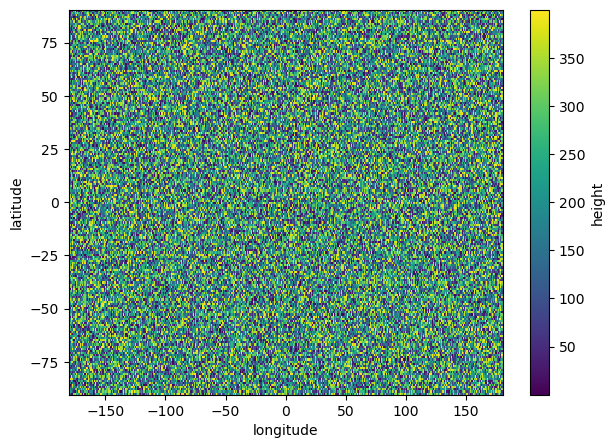

In [13]:
_ = da.plot(figsize=(7,5))

## `Dataset`

A `dataset` is a collection of `data arrays`:

In [15]:
ds = xr.Dataset(
    data_vars={
        "a": (("x", "y"), np.ones((3, 4))),                # 2D Array
        "b": ("t", np.full((8,), 3), {"attr": "value"})  # 1D array
    },
    coords={"x": [-1, 0, 1]},
    attrs={"attr": "value"}
)
ds

<xarray.Dataset>
Dimensions:  (x: 3, y: 4, t: 8)
Coordinates:
  * x        (x) int64 -1 0 1
Dimensions without coordinates: y, t
Data variables:
    a        (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    b        (t) int64 3 3 3 3 3 3 3 3
Attributes:
    attr:     value

We can define multi-date-type coordinates:

In [16]:
ds = xr.Dataset(
    data_vars={
        "a": (("x", "y"), np.ones((3, 4))),
        "b": (("t", "x"), np.full((8, 3), 3))
    },
    coords={
        "x": ["a", "b", "c"],                                  # Categories
        "y": np.arange(4),                                     # Numbers
        "t": pd.date_range("2020-07-05", periods=8, freq="D")  # Dates
    },
    attrs={"attr": "value"}
)
ds

<xarray.Dataset>
Dimensions:  (x: 3, y: 4, t: 8)
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3
  * t        (t) datetime64[ns] 2020-07-05 2020-07-06 ... 2020-07-11 2020-07-12
Data variables:
    a        (x, y) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    b        (t, x) int64 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Attributes:
    attr:     value

*Note*: `XArray` uses `nan` as its default missing value.

Let's create a dataset with two variables along `latitude` and `longitude`: `altitude` and `gravity_anomaly`:

In [17]:
# Generate the values of the two variables
alt = rng.random((180, 360)) * 400
gravity_anomaly = rng.random((180, 360)) * 400 - 200

# Create the dataset
ds = xr.Dataset(
    data_vars={
        "altitude": (("latitude", "longitude"), alt, {"ellipsoid": "wgs84"}),
        "gravity_anomaly": (("latitude", "longitude"), gravity_anomaly, {"ellipsoid": "grs80"})
    },
    coords={
        "latitude": ("latitude", np.linspace(-90, 90, num=180), {"type": "geodetic"}),
        "longitude": ("longitude", np.linspace(-180, 180, num=360), {"type": "greenwich"})
    }
)
ds

<xarray.Dataset>
Dimensions:          (latitude: 180, longitude: 360)
Coordinates:
  * latitude         (latitude) float64 -90.0 -88.99 -87.99 ... 87.99 88.99 90.0
  * longitude        (longitude) float64 -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    altitude         (latitude, longitude) float64 192.4 101.9 ... 303.5 121.3
    gravity_anomaly  (latitude, longitude) float64 186.1 -20.97 ... 133.2 -175.9

## Data Manipulation

Let's demonstrate how we can manipulate `XArray` objects:

In [18]:
# Create an array
arr = np.random.rand(3, 4)

# Use it to create a data array
da = xr.DataArray(arr, dims=("x", "y"))
da

<xarray.DataArray (x: 3, y: 4)>
array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318],
       [0.4236548 , 0.64589411, 0.43758721, 0.891773  ],
       [0.96366276, 0.38344152, 0.79172504, 0.52889492]])
Dimensions without coordinates: x, y

### `isel`

Similar to Pandas, we can select by index:

In [20]:
da.isel(x=1, y=3)

<xarray.DataArray ()>
array(0.891773)

The same applies to datasets:

In [22]:
# Create a dataset
ds = xr.Dataset(
    data_vars={
        "a": (("x", "y"), np.random.rand(3, 4)),
        "b": (("x", "y"), np.random.rand(3, 4))
    }
)

# Select the variable values at the second x/y
ds.isel(x=1, y=1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 0.437
    b        float64 0.102

Slicing a data array is also possible:

In [23]:
ds["a"][:2, :1]  # x & y slicing

<xarray.DataArray 'a' (x: 2, y: 1)>
array([[0.61209572],
       [0.3595079 ]])
Dimensions without coordinates: x, y

.. same with datasets:

In [24]:
ds.isel(x=slice(None, 2), y=slice(None, 1))

<xarray.Dataset>
Dimensions:  (x: 2, y: 1)
Dimensions without coordinates: x, y
Data variables:
    a        (x, y) float64 0.6121 0.3595
    b        (x, y) float64 0.3154 0.9884

### `sel`

We use the corrdinate values to directly slice the datasets/arrays:

Let's create a data array with coordinates:

In [25]:
da = xr.DataArray(
    np.random.rand(4, 6),
    dims=("x", "t"),
    coords={
        "x": [2, 9.9, 13, 14],
        "t": pd.date_range("2009-01-05", periods=6, freq="M")
    }
)
da

<xarray.DataArray (x: 4, t: 6)>
array([[0.15896958, 0.11037514, 0.65632959, 0.13818295, 0.19658236,
        0.36872517],
       [0.82099323, 0.09710128, 0.83794491, 0.09609841, 0.97645947,
        0.4686512 ],
       [0.97676109, 0.60484552, 0.73926358, 0.03918779, 0.28280696,
        0.12019656],
       [0.2961402 , 0.11872772, 0.31798318, 0.41426299, 0.0641475 ,
        0.69247212]])
Coordinates:
  * x        (x) float64 2.0 9.9 13.0 14.0
  * t        (t) datetime64[ns] 2009-01-31 2009-02-28 ... 2009-05-31 2009-06-30

Select based on the actual grid values:

In [26]:
da.sel(x=9.9, t="2009-01-31")

<xarray.DataArray ()>
array(0.82099323)
Coordinates:
    x        float64 9.9
    t        datetime64[ns] 2009-01-31

We we are not sure of the values, we can select by nearest:

In [27]:
da.sel(x=9.8, t="2009-01-13", method="nearest")

<xarray.DataArray ()>
array(0.82099323)
Coordinates:
    x        float64 9.9
    t        datetime64[ns] 2009-01-31

We can also slice by values:

In [28]:
da.sel(x=[9.9, 13], t=slice("2009", "2010"))

<xarray.DataArray (x: 2, t: 6)>
array([[0.82099323, 0.09710128, 0.83794491, 0.09609841, 0.97645947,
        0.4686512 ],
       [0.97676109, 0.60484552, 0.73926358, 0.03918779, 0.28280696,
        0.12019656]])
Coordinates:
  * x        (x) float64 9.9 13.0
  * t        (t) datetime64[ns] 2009-01-31 2009-02-28 ... 2009-05-31 2009-06-30

We can drop a range (opposite of slicing):

In [29]:
da.drop_sel(x=[9.9, 13])

<xarray.DataArray (x: 2, t: 6)>
array([[0.15896958, 0.11037514, 0.65632959, 0.13818295, 0.19658236,
        0.36872517],
       [0.2961402 , 0.11872772, 0.31798318, 0.41426299, 0.0641475 ,
        0.69247212]])
Coordinates:
  * x        (x) float64 2.0 14.0
  * t        (t) datetime64[ns] 2009-01-31 2009-02-28 ... 2009-05-31 2009-06-30

## Reading Data

Next, let's load a real dataset:

In [30]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Let us slice the data by latitude and longitude:

In [31]:
ds.isel(lat=slice(None, 30), lon=slice(20, 40))

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 20)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 250.0 252.5 255.0 257.5 ... 290.0 292.5 295.0 297.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 246.5 247.8 248.6 ... 300.4 300.7 300.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

One difference is that XArray's slicing is inclusive of the rightmost value:

In [32]:
ds.sel(lat=75, time=slice("2013-01-01", "2013-10-15"))

<xarray.Dataset>
Dimensions:  (time: 1152, lon: 53)
Coordinates:
    lat      float32 75.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-10-15T18:00:00
Data variables:
    air      (time, lon) float32 241.2 242.5 243.5 244.0 ... 259.3 259.3 259.2
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Masking is similar Pandas in the sense that we need to create a binary mask used to filter the data:

In [33]:
ds.where(ds.lat < 0.0)

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

*Note*: we don't want to assign to parts of a data arrays because **dask** (for HPC) arrays are immutable.

## Computation with `XArray`

In [2]:
ds = xr.open_dataset("./data/raster/ecmwf_forecasts.nc")
ds

<xarray.Dataset>
Dimensions:        (forecast_time: 583, latitude: 121, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2010-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    lead_time      timedelta64[ns] ...
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time) datetime64[ns] ...
Data variables:
    t2m            (forecast_time, latitude, longitude) float32 ...
    tp             (forecast_time, latitude, longitude) float32 ...

Let's select the first forecast and visualize:

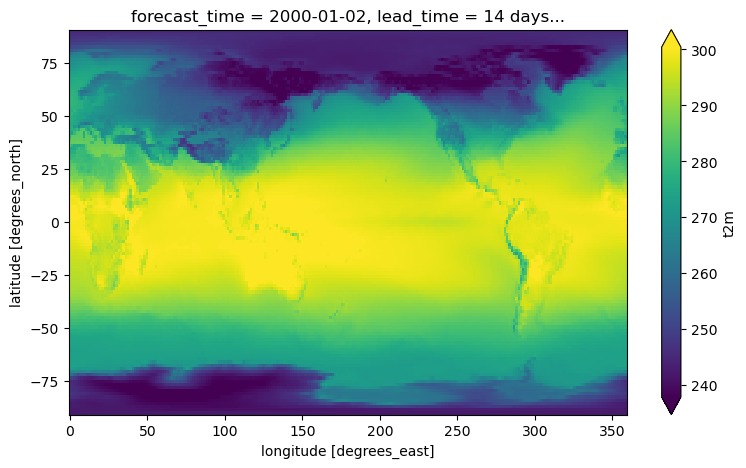

In [3]:
_ = ds["t2m"].isel(forecast_time=0).plot(robust=True, figsize=(9, 5))

Let's get the 2m temperature data array:

In [4]:
t2m = ds["t2m"]
t2m

<xarray.DataArray 't2m' (forecast_time: 583, latitude: 121, longitude: 240)>
[16930320 values with dtype=float32]
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2010-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    lead_time      timedelta64[ns] ...
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time) datetime64[ns] ...

In [5]:
# Kelvin to C
t2m_c = t2m - 273.15  # Automatic broadcasting
t2m_c

<xarray.DataArray 't2m' (forecast_time: 583, latitude: 121, longitude: 240)>
array([[[-28.066788, -28.066788, -28.066788, ..., -28.066788,
         -28.066788, -28.066788],
        [-27.263718, -27.240921, -27.219131, ..., -27.325836,
         -27.304276, -27.283646],
        [-26.201614, -26.140244, -26.08197 , ..., -26.459503,
         -26.374756, -26.287003],
        ...,
        [-30.353836, -30.472015, -30.589584, ..., -30.096588,
         -30.183197, -30.268631],
        [-30.960068, -30.98497 , -31.010056, ..., -30.87471 ,
         -30.902863, -30.931183],
        [-31.074783, -31.074783, -31.074783, ..., -31.074783,
         -31.074783, -31.074783]],

       [[-27.937927, -27.937927, -27.937927, ..., -27.937927,
         -27.937927, -27.937927],
        [-27.226593, -27.205322, -27.184189, ..., -27.277481,
         -27.260117, -27.243195],
        [-26.319763, -26.273148, -26.229156, ..., -26.551178,
         -26.476913, -26.397354],
...
        [-27.790817, -27.88887 , -27.987167, ..., -27.603378,
         -27.667465, -27.728806],
        [-28.570114, -28.582764, -28.595993, ..., -28.525711,
         -28.54042 , -28.555115],
        [-29.421524, -29.421524, -29.421524, ..., -29.421524,
         -29.421524, -29.421524]],

       [[-25.973343, -25.973343, -25.973343, ..., -25.973343,
         -25.973343, -25.973343],
        [-26.412872, -26.408646, -26.404236, ..., -26.420975,
         -26.418457, -26.415878],
        [-26.343689, -26.33847 , -26.335892, ..., -26.462097,
         -26.42479 , -26.384415],
        ...,
        [-30.72792 , -30.836334, -30.944199, ..., -30.471191,
         -30.558975, -30.643356],
        [-31.095413, -31.128357, -31.161453, ..., -30.99498 ,
         -31.028397, -31.06186 ],
        [-31.306488, -31.306488, -31.306488, ..., -31.306488,
         -31.306488, -31.306488]]], dtype=float32)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2010-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    lead_time      timedelta64[ns] ...
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time) datetime64[ns] ...

We recommend to keep using `XArray`'s `DataArray` or `Dataset` objects throughout our session. We would only export raw numpy arrays at the end of the "data preprocessing" stage:

In [6]:
# Compute a new data array
f = 0.5 * np.log(t2m_c ** 2)

/Users/akramz/miniconda3/envs/geospatial_primer/lib/python3.10/site-packages/xarray/core/computation.py:769: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


### Reductions

Let's plot the temperature annual averages as a timeseries:

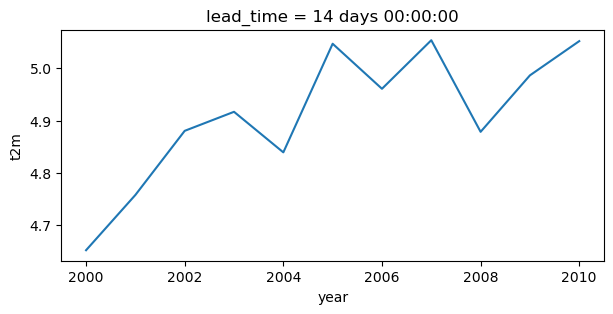

In [7]:
_ = (t2m - 273.15).mean(["latitude", "longitude"]).groupby("forecast_time.year").mean().plot(figsize=(7, 3))

Spatial pixel sizes in our grid are not the same, we need to properly weight before aggregating: 

In [8]:
# Create the weights
weights = np.cos(np.deg2rad(t2m.latitude))

# Automatice broadcasting
(t2m * weights)

<xarray.DataArray (forecast_time: 583, latitude: 121, longitude: 240)>
array([[[1.50070182e-14, 1.50070182e-14, 1.50070182e-14, ...,
         1.50070182e-14, 1.50070182e-14, 1.50070182e-14],
        [6.43655234e+00, 6.43714909e+00, 6.43771947e+00, ...,
         6.43492627e+00, 6.43549066e+00, 6.43603069e+00],
        [1.29242796e+01, 1.29274915e+01, 1.29305413e+01, ...,
         1.29107827e+01, 1.29152181e+01, 1.29198107e+01],
        ...,
        [1.27069691e+01, 1.27007841e+01, 1.26946310e+01, ...,
         1.27204324e+01, 1.27158996e+01, 1.27114284e+01],
        [6.33979318e+00, 6.33914131e+00, 6.33848465e+00, ...,
         6.34202758e+00, 6.34129064e+00, 6.34054930e+00],
        [1.48228316e-14, 1.48228316e-14, 1.48228316e-14, ...,
         1.48228316e-14, 1.48228316e-14, 1.48228316e-14]],

       [[1.50149086e-14, 1.50149086e-14, 1.50149086e-14, ...,
         1.50149086e-14, 1.50149086e-14, 1.50149086e-14],
        [6.43752415e+00, 6.43808096e+00, 6.43863416e+00, ...,
         6.43619206e+00, 6.43664661e+00, 6.43708957e+00],
        [1.29180962e+01, 1.29205358e+01, 1.29228381e+01, ...,
         1.29059848e+01, 1.29098715e+01, 1.29140354e+01],
...
        [1.28411071e+01, 1.28359754e+01, 1.28308310e+01, ...,
         1.28509169e+01, 1.28475629e+01, 1.28443526e+01],
        [6.40235487e+00, 6.40202374e+00, 6.40167744e+00, ...,
         6.40351721e+00, 6.40313216e+00, 6.40274751e+00],
        [1.49240645e-14, 1.49240645e-14, 1.49240645e-14, ...,
         1.49240645e-14, 1.49240645e-14, 1.49240645e-14]],

       [[1.51352047e-14, 1.51352047e-14, 1.51352047e-14, ...,
         1.51352047e-14, 1.51352047e-14, 1.51352047e-14],
        [6.45882488e+00, 6.45893552e+00, 6.45905095e+00, ...,
         6.45861278e+00, 6.45867869e+00, 6.45874619e+00],
        [1.29168440e+01, 1.29171171e+01, 1.29172521e+01, ...,
         1.29106470e+01, 1.29125995e+01, 1.29147126e+01],
        ...,
        [1.26873910e+01, 1.26817171e+01, 1.26760719e+01, ...,
         1.27008272e+01, 1.26962329e+01, 1.26918168e+01],
        [6.33625025e+00, 6.33538788e+00, 6.33452152e+00, ...,
         6.33887928e+00, 6.33800454e+00, 6.33712859e+00],
        [1.48086438e-14, 1.48086438e-14, 1.48086438e-14, ...,
         1.48086438e-14, 1.48086438e-14, 1.48086438e-14]]])
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2010-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
    lead_time      timedelta64[ns] 14 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time) datetime64[ns] ...

In [9]:
# ... however, this is better!
t2m_weighted = (t2m - 273.15).weighted(weights)
t2m_weighted

DataArrayWeighted with weights along dimensions: latitude

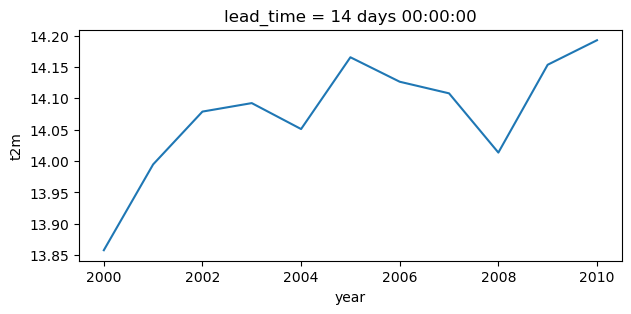

In [10]:
# We plot the weighted pixels
_ = t2m_weighted.mean(["latitude", "longitude"])\
    .groupby("forecast_time.year")\
    .mean().plot(figsize=(7, 3))

We can also plot the time-series for a specific location of interest:

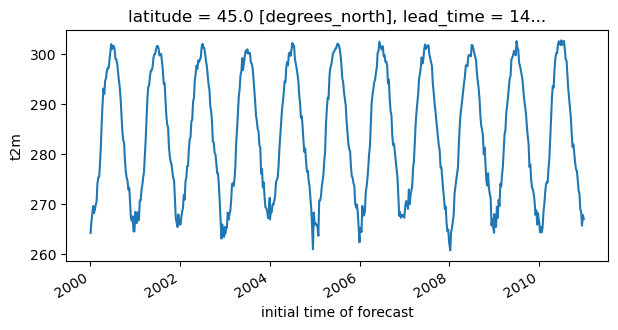

In [11]:
_ = t2m.isel(latitude=30, longitude=40).plot(figsize=(7, 3))

### `GroupBy`

Let's calculate the monthly climatology:

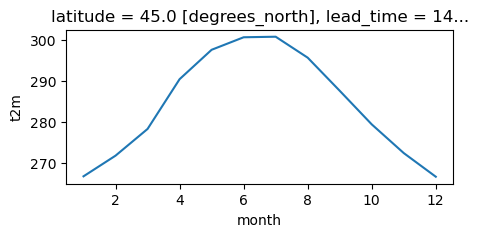

In [12]:
# Calculate climatology
clim = t2m.groupby("forecast_time.month").mean("forecast_time")

# Visualize the seasonal cycle for a location of interest
_ = clim.isel(latitude=30, longitude=40).plot(figsize=(5, 2))

Let's take a look at the `tp` seasonal cycle by latitude:

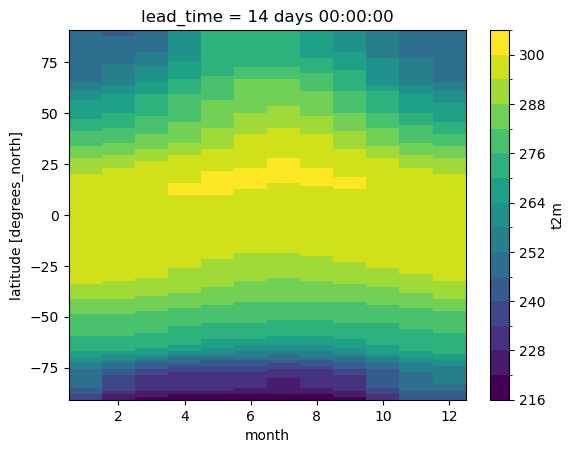

In [13]:
_ = clim.mean("longitude").plot(x="month", y="latitude", levels=15)

Let's conduct a transformation to remove the seasonal climatology:

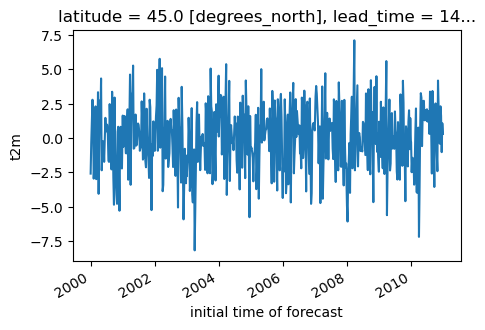

In [14]:
# Remove the monthly climatology
t2m_anoms = t2m.groupby("forecast_time.month").map(lambda grp: grp - grp.mean("forecast_time"))

# Visualize for a single location
_ = t2m_anoms.isel(latitude=30, longitude=40).plot(figsize=(5, 3))

We can also use `resample` (like Pandas):

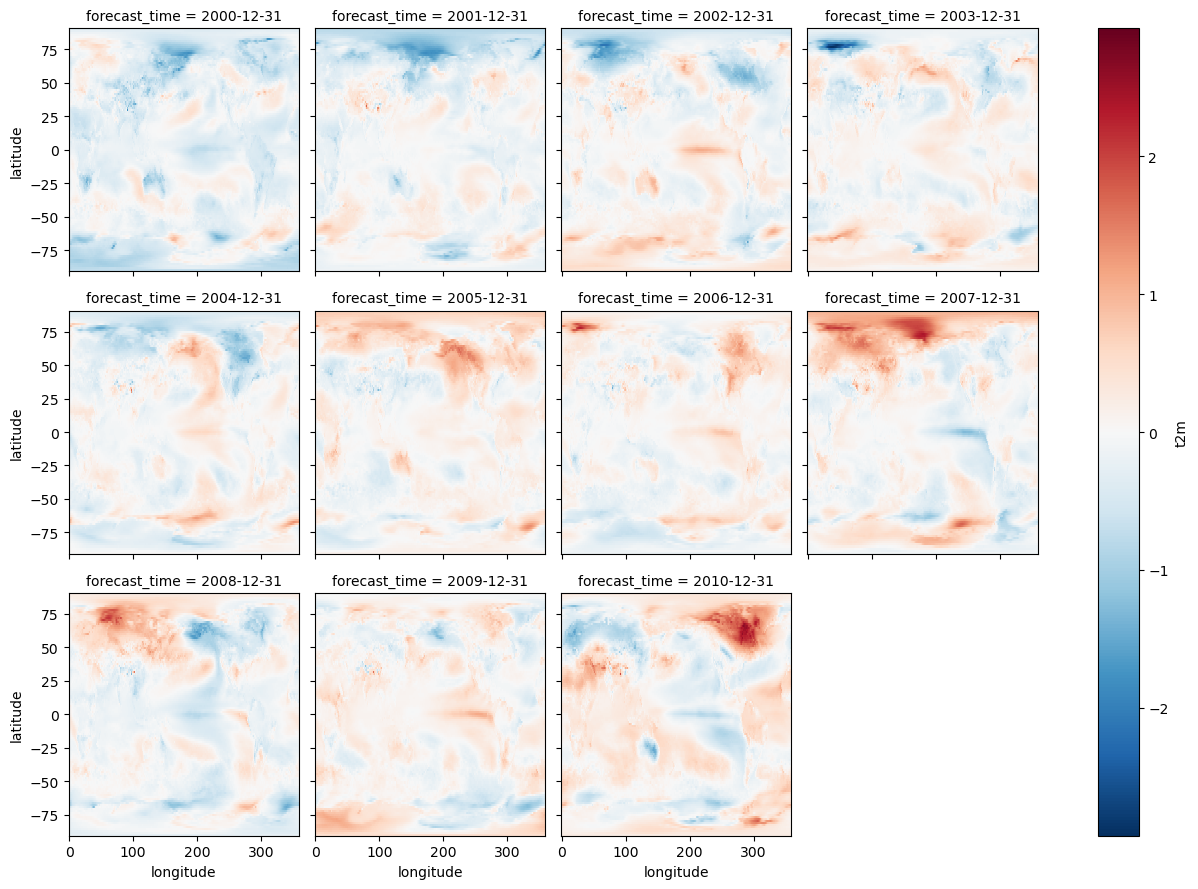

In [15]:
t2m_anoms_1y = t2m_anoms.resample(forecast_time="1Y").mean("forecast_time")
t2m_anoms_1y.plot(col="forecast_time", col_wrap=4)

## Visualization

We use histograms to visualize variable distributions:

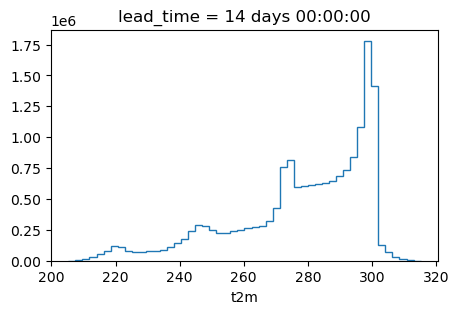

In [16]:
_ = ds["t2m"].plot(bins=50, histtype="step", stacked=True, fill=False, figsize=(5, 3))

We can also visualize 2D arrays:

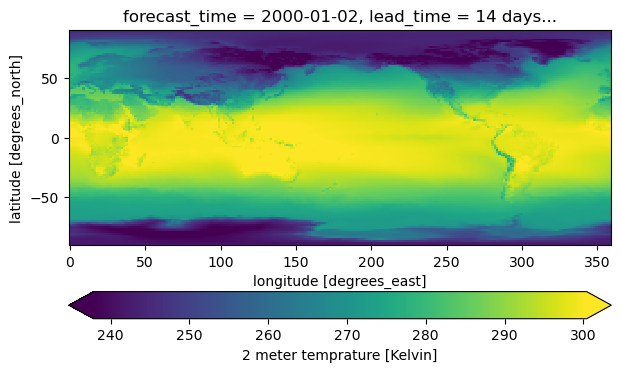

In [17]:
_ = ds["t2m"].isel(forecast_time=0).plot(
    robust=True,
    cbar_kwargs={"label": "2 meter temprature [Kelvin]", 
                 "orientation": "horizontal"},
    figsize=(7, 4)
)

We can change the styling through matplotlib:

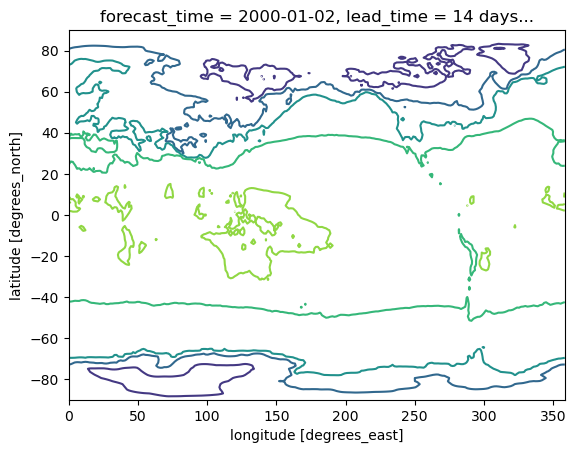

In [18]:
_ = ds["t2m"].isel(forecast_time=0).plot.contour()

Let's visualize 2m-temperature longitude variation for 3 latitude values of interest:

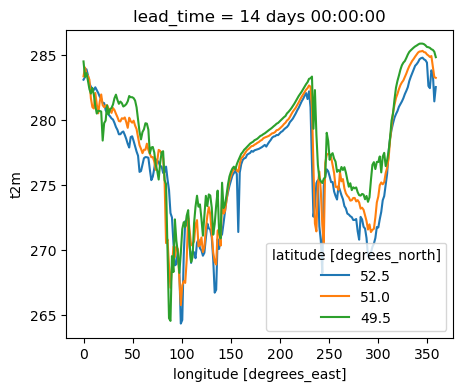

In [19]:
_ = ds["t2m"].mean("forecast_time").isel(latitude=[25, 26, 27]).plot(hue="latitude", figsize=(5, 4))

### Workflow for Complex Plots

To produce complex plots following these steps:
1. Custom-create the `ax` using `plt.subplots()`.
2. Plot with `xarray` using `.plot(ax=ax)`.
3. Further customize the `ax`es directly using `matplotlib`. 

### Facets

Let's experiment with plotting 3D data:

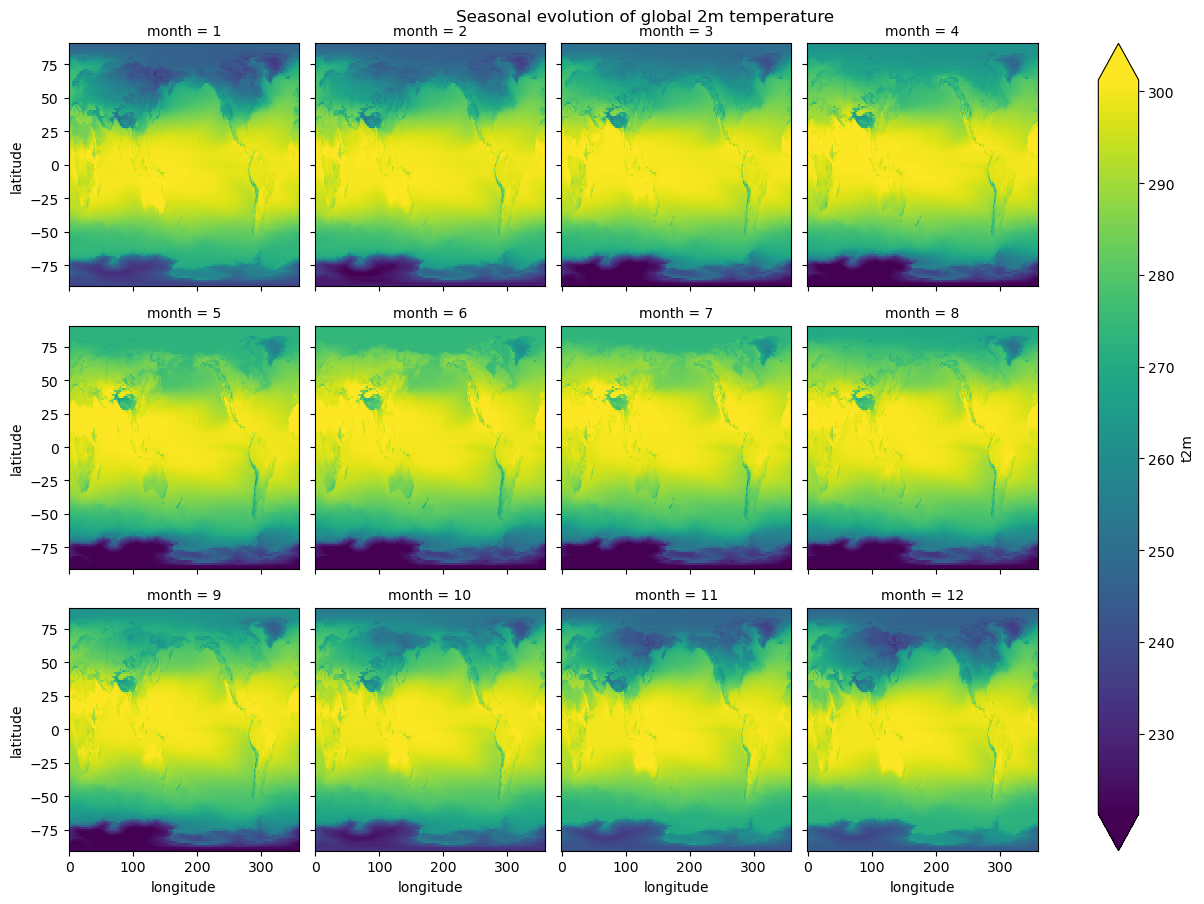

In [20]:
# Get the data array
da = ds["t2m"]

# Group by month of year and calculate monthly means
da = da.groupby("forecast_time.month").mean()

# Plot
fg = da.plot(col="month", col_wrap=4, robust=True)
_ = fg.fig.suptitle("Seasonal evolution of global 2m temperature", y=1)
plt.show()

## Resources

- [Official Documentation](https://docs.xarray.dev/en/stable/): The primary resource for XArray is its official documentation. It covers various topics, including installation, user guide, examples, and API reference.
- [XArray for multidimensional data](https://rabernat.github.io/research_computing_2018/xarray.html): This introductory tutorial by Ryan Abernat covers the basics of XArray and its role in handling multidimensional data.
- [Earth and Environmental Data Science with XArray](https://pangeo.io/): The Pangeo project provides a wealth of resources related to using XArray for Earth and environmental data science, including tutorials and examples.
- [XArray Tutorial for Geospatial Data](http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/): This tutorial by Stephan Hoyer demonstrates the use of XArray and Dask for processing large geospatial datasets.
- [XArray Exercises](https://github.com/xarray-contrib/xarray-tutorial): This GitHub repository by Tom Nicholas contains exercises and solutions for learning XArray.

---